[Back to Index](index.ipynb)

## Generate Summary Statistics for Sacramento County

Begin by importing all python modules we will need.

In [1]:
# A 'magic' command to display plots inline
%matplotlib inline

import requests
import pandas as pd
from datetime import datetime
import itertools
import calendar
import seaborn as sns; sns.set(style="ticks", color_codes=True)

### 1. Get projections

The code in the next cell contains a bunch of functions to:
    - fetch annual averages of Max. Temp, Min. Temp and Precipitation for 4 GCMs and 2 scenarios for Sacramento County from the API
    - convert units
    - return a new dataframe that contains all the data
    
Just run the cell, you can go over the code at your leisure.

In [2]:
def kelvin_to_F(val):
    return  (val - 273.15) * 9/5 + 32

def kgm2s_to_inchyear(row):
    year = row.event.year
    if calendar.isleap(year):
        return (row.image * 86400) * 0.0393701 * 366
    else:
        return (row.image * 86400) * 0.0393701 * 365

def get_projections():
    # Create an empty list to hold dataframes
    df_list = []

    # Make a combined list of GCMs, scenarios, climate variables for looping
    climvar = ['tasmax', 'tasmin', 'pr']
    period = ['year']
    models = ['CanESM2', 'CNRM-CM5', 'HadGEM2-ES', 'MIROC5']
    scenarios = ['rcp45', 'rcp85']
    zipped = itertools.product(climvar, period, models, scenarios)

    # Request header
    headers = {'ContentType': 'json'}
    
    # Loop through zipped
    for item in zipped:
        # Create slug
        slug = '_'.join(item)
        url = 'http://api.cal-adapt.org/api/series/' + slug + '/rasters/?pagesize=94&stat=mean&ref=/api/counties/34/'
        # Make request
        response = requests.get(url, headers=headers)

        # Get data
        if response.status_code == requests.codes.ok:
            print('Processing:', slug)
            data = response.json()
            # Create temp dataframe
            df = pd.DataFrame(data['results'])
            # Change format of `event` field to datetime
            df['event'] = pd.to_datetime(df['event'], format='%Y-%m-%d')
            # The data from API should be sorted, but sort ascending to be sure
            df = df.sort_values('event')  
            # Convert units
            if 'tas' in slug:
                df.image = df.image.apply(lambda x: kelvin_to_F(x))
            else:
                df.image = df.apply(kgm2s_to_inchyear, axis=1)
            # Discard all columns except event and image
            df = df[['event', 'image']]
            df['climvar'] = item[0]
            df['model'] = item[2]
            df['scenario'] = item[3]
            df_list.append(df)          
        else:
            print('Failed:', slug)
    # Combine all the dataframes into one and return
    return pd.concat(df_list)

Execute the `get_projections()` function. If all goes well, you should see a list of messages as the code process each timeseries.

In [3]:
projections = get_projections()

Processing: tasmax_year_CanESM2_rcp45
Processing: tasmax_year_CanESM2_rcp85
Processing: tasmax_year_CNRM-CM5_rcp45
Processing: tasmax_year_CNRM-CM5_rcp85
Processing: tasmax_year_HadGEM2-ES_rcp45
Processing: tasmax_year_HadGEM2-ES_rcp85
Processing: tasmax_year_MIROC5_rcp45
Processing: tasmax_year_MIROC5_rcp85
Processing: tasmin_year_CanESM2_rcp45
Processing: tasmin_year_CanESM2_rcp85
Processing: tasmin_year_CNRM-CM5_rcp45
Processing: tasmin_year_CNRM-CM5_rcp85
Processing: tasmin_year_HadGEM2-ES_rcp45
Processing: tasmin_year_HadGEM2-ES_rcp85
Processing: tasmin_year_MIROC5_rcp45
Processing: tasmin_year_MIROC5_rcp85
Processing: pr_year_CanESM2_rcp45
Processing: pr_year_CanESM2_rcp85
Processing: pr_year_CNRM-CM5_rcp45
Processing: pr_year_CNRM-CM5_rcp85
Processing: pr_year_HadGEM2-ES_rcp45
Processing: pr_year_HadGEM2-ES_rcp85
Processing: pr_year_MIROC5_rcp45
Processing: pr_year_MIROC5_rcp85


Explore the `projections` dataframe

In [5]:
projections = projections.reset_index()
projections.head()

,index,event,image,climvar,model,scenario
0,0,2006-01-01,74.745883,tasmax,CanESM2,rcp45
1,1,2007-01-01,76.200300,tasmax,CanESM2,rcp45
2,2,2008-01-01,76.365064,tasmax,CanESM2,rcp45
3,3,2009-01-01,76.199539,tasmax,CanESM2,rcp45
4,4,2010-01-01,77.256619,tasmax,CanESM2,rcp45


### 2. Get historical observed data

The code in the next cell contains a bunch of functions to:
    - fetch annual averages of Max. Temp, Min. Temp and Precipitation for the livneh data for Sacramento County from the API
    - convert units
    - return a new dataframe that contains all the data
    
Just run the cell, you can go over the code at your leisure.

In [5]:
def celsius_to_F(val):
    return val * 9/5 + 32 

def mmday_to_inchyear(row):
    year = row.event.year
    if calendar.isleap(year):
        return row.image * 0.0393701 * 366
    else:
        return row.image * 0.0393701 * 365

def get_observed():
    # Create an empty list to hold dataframes
    df_list = []

    # Make a combined list of GCMs, scenarios, climate variables for looping
    climvar = ['tasmax', 'tasmin', 'pr']
    period = ['year']
    zipped = itertools.product(climvar, period, ['livneh'])
    
    # Request header
    headers = {'ContentType': 'json'}

    # Loop through zipped
    for item in zipped:
        # Create slug
        slug = '_'.join(item)
        url = 'http://api.cal-adapt.org/api/series/' + slug + '/rasters/?pagesize=64&stat=mean&ref=/api/counties/34/'
        # Make request
        response = requests.get(url, headers=headers)

        # Get data
        if response.status_code == requests.codes.ok:
            print('Processing:', slug)
            data = response.json()
            # Create temp dataframe
            df = pd.DataFrame(data['results'])
            # Change format of `event` field to datetime
            df.event = pd.to_datetime(df.event, format='%Y-%m-%d')
            # The data from API should be sorted, but sort ascending to be sure
            df = df.sort_values('event')     
            # Convert units
            if 'tas' in slug:
                df.image = df.image.apply(lambda x: celsius_to_F(x))
            else:
                df.image = df.apply(mmday_to_inchyear, axis=1)
            col_list = ['event', 'image']
            df = df[col_list]
            df['climvar'] = item[0]
            df['model'] = 'livneh'
            df['scenario'] = 'historical'
            df_list.append(df)          
        else:
            print('Failed:', slug)
    # Combine all the dataframes into one and return
    return pd.concat(df_list)

Execute the `get_observed()` function. If all goes well, you should see a list of messages as the code process each timeseries

In [6]:
observed = get_observed()

Processing: tasmax_year_livneh
Processing: tasmin_year_livneh
Processing: pr_year_livneh


Explore the observed dataframe

In [7]:
observed.head()

,event,image,climvar,model,scenario
0,1950-01-01,74.893606,tasmax,livneh,historical
1,1951-01-01,74.096737,tasmax,livneh,historical
2,1952-01-01,73.463145,tasmax,livneh,historical
3,1953-01-01,73.866604,tasmax,livneh,historical
4,1954-01-01,72.737019,tasmax,livneh,historical


### 3. Resampling

Resampling is similar to a groupby: you split the time series into groups (30 year buckets below), apply a function to each group (mean), and combine the result (one row per group).

In [8]:
df = pd.concat([projections, observed])
df.tail()

,event,image,climvar,model,scenario
59,2009-01-01,18.207536,pr,livneh,historical
60,2010-01-01,25.633581,pr,livneh,historical
61,2011-01-01,19.996797,pr,livneh,historical
62,2012-01-01,24.405545,pr,livneh,historical
63,2013-01-01,6.264452,pr,livneh,historical


In [9]:
baseline = df[(df.event >= '1961-01-01') & (df.event <= '1990-01-01')]
baseline = baseline.groupby(['climvar', 'scenario', 'model'])['image'].agg(['mean', 'max', 'min', 'std'])
df_baseline = pd.DataFrame(baseline)
df_baseline

,,,mean,max,min,std
climvar,scenario,model,,,,
pr,historical,livneh,18.358115,37.639325,6.723825,6.602885
tasmax,historical,livneh,73.976728,76.498226,71.147214,1.295515
tasmin,historical,livneh,48.452321,50.631000,46.488695,1.017017


In [10]:
projections_2020_2050 = df[(df.event >= '2020-01-01') & (df.event <= '2050-01-01')]
projections_2020_2050 = projections_2020_2050.groupby(['climvar', 'scenario', 'model'])['image'].agg(['mean', 'max', 'min', 'std'])
df_2020_2050 = pd.DataFrame(projections_2020_2050)
df_2020_2050

mean        max        min       std
climvar scenario model                                                
pr      rcp45    CNRM-CM5    25.244377  40.696003  12.766277  7.064644
                 CanESM2     20.351793  38.833957  10.263318  6.476784
                 HadGEM2-ES  18.642809  33.825826   7.275011  5.819849
                 MIROC5      19.590382  29.062910   9.333022  6.636499
        rcp85    CNRM-CM5    22.185210  35.765385  10.660914  6.348402
                 CanESM2     20.028635  35.247056   8.382266  7.671779
                 HadGEM2-ES  20.219224  38.198301  10.593186  7.058904
                 MIROC5      18.165717  29.156025  10.213474  5.054121
tasmax  rcp45    CNRM-CM5    76.855003  78.875474  74.051601  1.196305
                 CanESM2     78.134308  79.871302  76.183121  0.836750
                 HadGEM2-ES  77.645339  79.847598  75.112631  1.260639
                 MIROC5      77.145848  79.553736  73.976613  1.525232
        rcp85    CNRM-CM5    77.082988  79.629231  75.219985  1.177509
                 CanESM2     78.780165  80.567504  76.186310  1.106148
                 HadGEM2-ES  78.282165  80.595991  76.209434  1.117128
                 MIROC5      77.713073  80.981732  74.776835  1.513998
tasmin  rcp45    CNRM-CM5    51.538618  53.202713  49.390325  1.049239
                 CanESM2     52.350519  55.108834  50.256111  1.106704
                 HadGEM2-ES  51.200004  53.187962  49.751746  0.968823
                 MIROC5      51.008501  52.681603  49.305189  0.828272
        rcp85    CNRM-CM5    51.599422  53.641586  49.256877  1.065843
                 CanESM2     52.926814  55.857879  50.496805  1.440793
                 HadGEM2-ES  51.986303  54.271245  49.644683  1.088418
                 MIROC5      51.381532  53.524120  49.368362  0.876600

In [11]:
projections_2070_2099 = df[(df.event >= '2070-01-01') & (df.event <= '2099-01-01')]
projections_2070_2099 = projections_2070_2099.groupby(['climvar', 'scenario', 'model'])['image'].agg(['mean', 'max', 'min', 'std'])
df_2070_2099 = pd.DataFrame(projections_2070_2099)
df_2070_2099

mean        max        min        std
climvar scenario model                                                 
pr      rcp45    CNRM-CM5    24.057855  41.709344  10.210835   8.513977
                 CanESM2     21.890104  35.443466   7.295686   7.563886
                 HadGEM2-ES  18.790472  33.977283   8.345804   6.794935
                 MIROC5      16.566953  31.519082   7.125082   5.923228
        rcp85    CNRM-CM5    24.940826  42.208371  11.003425   8.110692
                 CanESM2     25.718367  47.632457   6.561733  10.499727
                 HadGEM2-ES  20.195048  33.633241   8.261492   6.565622
                 MIROC5      17.877358  35.990775   7.181357   6.080446
tasmax  rcp45    CNRM-CM5    79.016367  80.686890  77.611878   0.894106
                 CanESM2     80.037823  81.895975  78.377378   0.879353
                 HadGEM2-ES  80.380028  83.697171  77.130346   1.527731
                 MIROC5      79.651281  82.112929  77.111790   1.358926
        rcp85    CNRM-CM5    81.847283  83.843233  78.677076   1.195038
                 CanESM2     83.863493  87.190398  81.193032   1.515246
                 HadGEM2-ES  83.741072  85.869755  81.675941   1.107304
                 MIROC5      81.312075  84.295734  77.978301   1.605932
tasmin  rcp45    CNRM-CM5    53.448794  55.821382  51.257521   0.962541
                 CanESM2     54.124511  56.119993  51.051150   1.216653
                 HadGEM2-ES  53.765280  55.739073  52.213626   0.834637
                 MIROC5      52.488582  54.290164  50.957026   0.791370
        rcp85    CNRM-CM5    56.440377  59.295544  53.665760   1.513413
                 CanESM2     58.447670  61.925232  54.074080   1.841081
                 HadGEM2-ES  57.374879  59.637176  54.886951   1.181727
                 MIROC5      54.843240  56.580830  53.153711   0.947442

### 4. Export to Excel

In [12]:
writer = pd.ExcelWriter('output.xlsx')
df_baseline.to_excel(writer,'Baseline')
df_2020_2050.to_excel(writer,'2020-2050')
df_2070_2099.to_excel(writer,'2070-2099')
writer.save()

### 5. Make charts

Pandas comes bundled with matplotlib, a very powerful plotting libray.

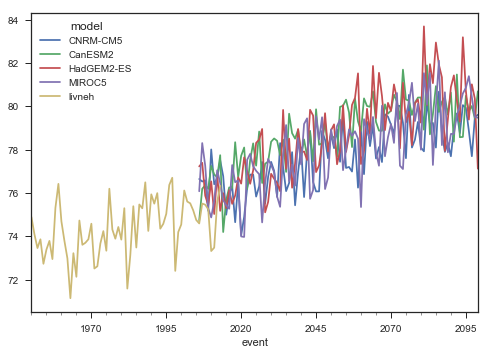

In [13]:
tasmax_rcp45 = df.loc[(df['climvar'] == 'tasmax') & (df['scenario'] != 'rcp85')]
tasmax_rcp45 = tasmax_rcp45.pivot(index='event', columns='model', values='image')
plot = tasmax_rcp45.plot()
fig = plot.get_figure()
fig.savefig('output.png')